In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats
from Bio import SeqIO
from model import CouplingsModel

In [2]:
### 1. sample from MCMC with a markov process
###     Underlying distribution: AA only depends on previous position. Probability bigram matrix of alphabets based on war_and_peace.txt
### 2. Create a2m files from the samples
### 3. Train a potts model with plmc
### 4. Observe dependency matrices
np.random.seed(0)
ALPHABET_PROTEIN = '-ACDEFGHIKLMNPQRSTVWY'

In [3]:
### first learn the conditional probabilities
input_file = "war_and_peace.txt"

def build_bigram_freq_matrix(input_file):
    """
    Builds a matrix that represents the transitional
    probabilities between letters in input_file.
    
    bigram_freq_matrix[0][1] is the probability of
    transitioning from the 0th letter of the alphabet
    to the 1st letter of the alphabet, where letters
    are zero-indexed. ' ' (space) is denoted as the
    26th letter of the alphabet.
    """
    counts = np.ones([27, 27])
    with open(input_file, 'r', encoding='utf8') as f:
        for _ in range(100000):
            line = f.readline()
            if len(line) > 2:
                for i in range(len(line) - 2):
                    first_char = ord(line[i].upper()) - 65 if line[i].isalpha() else 26
                    second_char = ord(line[i+1].upper()) - 65 if line[i+1].isalpha() else 26
                    if not (first_char == 26 and second_char == 26) and first_char <= 26 and second_char <= 26:
                        counts[first_char][second_char] += 1
        bigram_freq_matrix = (counts.T / np.sum(counts, axis=1)).T
    return bigram_freq_matrix

freq_matrix = build_bigram_freq_matrix(input_file)

### freq_matrix is based on all 26 letters of the english alphabet + space
### map the matrix to protein alphabets
indices = []
for aa in list(ALPHABET_PROTEIN):
    if aa == '-':
        indices.append(26)
    else:
        indices.append(ord(aa)-ord('A'))


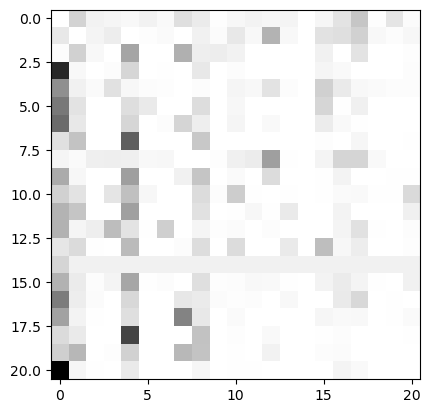

In [6]:
### only take letters in the protiein alphabet

protein_freq_matrix = freq_matrix[indices]
protein_freq_matrix = protein_freq_matrix[:, indices]

### normalize it so probabilities sum to 1
for x in protein_freq_matrix:
    x /= np.sum(x)

### check for valid probabilities

assert np.all(protein_freq_matrix >= 0) and np.all(protein_freq_matrix <= 1)
plt.imshow(protein_freq_matrix, cmap='binary', interpolation='none')    

In [13]:
def sample(bigram, length, first_letter):
    seq = first_letter
    cur_letter = first_letter
    while len(seq) < length:
        # iteratively append to the sequence according to bigram frequency
        bigram_freq = bigram[ALPHABET_PROTEIN.index(cur_letter)]
        
        # draw next letter from the given bigram distribution
        next_letter = np.random.choice(list(ALPHABET_PROTEIN), p=bigram_freq)
        seq += next_letter
        cur_letter = next_letter
    return seq

def draw_samples_MP(bigram, length, n):
    samples = []
    for _ in range(n):
        random_first_letter = np.random.choice(list(ALPHABET_PROTEIN))
        samples.append(sample(bigram, length, random_first_letter))
    return samples

In [15]:
data = draw_samples_MP(protein_freq_matrix, 5, 100000)